# Reinforcement Learning for Congestion Control

### What is being learned?

We are going to use reinforcement learning to train a function that given a state, returns an action that the
TCP sender ought to take. As you can imagine, the actions are:

* Increase the window
* Decrease the window
* Keep the window the same

To get into the weeds a bit, we added a couple actions for increasing & decreasing to give the algorithm a little
bit more leeway.

### Q Learning

Q learning is an iterative process for figuring out what that function should be.

Process:
1. Randomly choose actions at the beginning
2. After taking an action, evaluate the reward
3. Use that knowledge to update the Q table, which is table that for all states and action pairings figures out
the highest expected reward

**Example Q table:**

|         | Action 1 | Action 2 | Action 3 |   |
|---------|----------|----------|----------|---|
| State 1 | 5        | 2        | 3        |   |
| State 2 | 10       | 4        | 91       |   |
| State 3 | 1        | 7        | 8        |   |

In our case, our "state" is a sequence of historically seen RTTs, and each of the actions are as we described them above.

![bellman_equation](bellman_equation.png)
### But, we have sooo many states!

Since our sequences of round trip times are uncountably infinite, we cannot use a simple state table like this.

Instead, we approximate this table with a neural network, specifically, with one designed to store sequences, called an LSTM (Long short-term memory).

### Training the network:

Training our neural network is a little finicky

In [1]:
import time
import json
from typing import List, Dict, Tuple, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

In [2]:
import mpld3

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

from operator import itemgetter
mpld3.enable_notebook()

In [3]:

class LSTM_DQN(nn.Module):
    def __init__(self, config):
        super(LSTM_DQN,self).__init__()
        """
        self.h0 = Variable(torch.zeros(config["batch_size"], 2*config["n_layers"], config["hidden_dim"]//2))
        self.c0 = Variable(torch.zeros(config["batch_size"], 2*config["n_layers"], config["hidden_dim"]//2))
        self.W = nn.LSTM(config["input_dim"], config["hidden_dim"]//2,
                              num_layers=config["n_layers"],
                              dropout=config["rdropout"],
                              bidirectional=True,
                              batch_first=True,
                             )
        """
        self.W = nn.LSTM(config["input_dim"], config["hidden_dim"],batch_first=True)
        self.h0, self.c0 = (torch.zeros(1, 1, config["hidden_dim"]),
                torch.zeros(1, 1, config["hidden_dim"]))
        self.U = nn.Linear(config["hidden_dim"],config["output_dim"])
        
        ## look into initialization strategies                
        for param in self.W.parameters():
            if len(param.size()) > 1:
                nn.init.orthogonal(param)
                
        for param in self.U.parameters():
            if len(param.size()) > 1:
                nn.init.orthogonal(param)
    
    def forward(self, x):
        # apply LSTM
        batch_len, _, _ = x.size()
        
        h0 = self.h0.repeat(1, batch_len, 1)
        c0 = self.c0.repeat(1, batch_len, 1)
        
        out, _ = self.W(x, (h0,c0))

        return self.U(out[:,-1,:])

# What is the shape of X? (batch_size, sequence/history length, num_features)
# How to get the last hidden state produced by nn.LSTM? slice using [:,-1,:] (assuming batch_first=True)
# How to initialize multi-layer, bidirectional LSTMs?
# What is an appropriate way to initialize weights in a reinforcement context? Still orthonormal?
 

In [4]:
Actions = {
    'INCREASE_PERCENT': 0,
    'DECREASE_PERCENT': 1,
    'INCREASE_ABSOLUTE': 2,
    'DECREASE_ABSOLUTE': 3,
    'STAY': 4,
    'DECREASE_DRAMATIC': 5
}

DRAMATIC_PERCENT_CHANGE = 0.5
ABSOLUTE_CHANGE = 5
PERCENT_CHANGE = 0.05

Rewards = {
    'DROPPED_PACKET': -200,
    'DRAMATIC_RTT_INCREASE': -40000,
    'INCREASED_RTT': -200,
    'INCREASED_CWND_ABSOLUTE': 5,
    'INCREASED_CWND_PERCENTAGE': 7,
    'NO_REWARD': 0
}

#FEATURES = ['cwnd', 'dropped_packet', 'rtt']
FEATURES = ['rtt']

config = {
    "n_layers": 1,
    "hidden_dim": 15,
    "rdropout": .5, 
    "input_dim": len(FEATURES),
    "output_dim": len(Actions),
    "batch_size": 1,
}


RTT_CHANGE_THRESHOLD = 5
RTT_DRAMATIC_CHANGE_THRESHOLD = 10

RTT_AVERAGE_WINDOW = 10
BATCH_SIZE = 30
GAMMA = 0.992
#STATE_WINDOW_SIZE = 15
STATE_WINDOW_SIZE = 1
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 20
TARGET_UPDATE = 2
NUM_EPISODES = 5

In [5]:
DEFAULT_TIMEOUT = 2

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReinforcementStrategy(SenderStrategy):
    def __init__(self, policy_net, target_net, optimizer, config: Dict, episode_num: int, transitions: List[Dict]) -> None:
        self.cwnd = 1
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        self.timeout = DEFAULT_TIMEOUT
        self.fast_retransmitted_packets_in_flight = []

        self.duplicated_ack = None
        self.slow_start_thresholds = []
        
        self.next_packet_rewards = {} # Mapping of sequence number to action/state combination

        self.sequence_history_dict = {} # list with some fixed size
        self.transitions = transitions
        self.base_rtt = None
        self.rtt_average = None
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.episode = episode_num
        self.losses = []
        self.config = config
        
        super().__init__()

    def select_next_action(self, state: torch.tensor):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.episode / EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state.unsqueeze(0)).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.config['output_dim'])]], dtype=torch.long)

        
    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > self.timeout:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > self.timeout:
                    
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    
                    # Update reinforcement learning based on previous window size increase

                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                    self.sequence_history_dict[seq_num] = {
                        'cwnd': segment['cwnd'],
                        'rtt': 0,
                        'dropped_packet': True
                    }
                    current_state = self.compute_state(max(seq_num - STATE_WINDOW_SIZE, 0), seq_num)
                    current_state = self.state_to_tensor(current_state)

                    current_action = self.select_next_action(current_state)
                    self.update_cwnd(current_action)
                    self.update_q_function(seq_num, 0, True)
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack
            #print("received dup ack")
            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
            
                
                self.sequence_history_dict[ack['seq_num']] = {
                    'cwnd': ack['cwnd'],
                    'rtt': 0,
                    'dropped_packet': True
                }
                
                
                current_state = self.compute_state(max(seq_num - STATE_WINDOW_SIZE, 0), seq_num)
                current_state = self.state_to_tensor(current_state)

                current_action = self.select_next_action(current_state)
                
                self.update_cwnd(current_action)
                self.update_q_function(ack['seq_num'], 0, True)
                # Update reinforcement learning based on previous window size increase
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

                self.fast_retransmitted_packets_in_flight = []

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            self.rtt_recordings.append((time.time(), rtt))
            if self.base_rtt is None:
                self.base_rtt = rtt

            if self.rtt_average is None:
                self.rtt_average = rtt
            else:
                self.rtt_average = sum(self.rtts[-RTT_AVERAGE_WINDOW:])/len(self.rtts[-RTT_AVERAGE_WINDOW:])
            
            
            self.timeout = rtt * 1.2
            
            self.sequence_history_dict[ack['seq_num']] = {
                'cwnd': ack['cwnd'],
                'rtt': rtt,
                'dropped_packet': False,
                'seq_num': ack['seq_num']
            }
            
            current_state = self.compute_state(max(ack['seq_num'] - STATE_WINDOW_SIZE, 0), ack['seq_num'])
            current_state = self.state_to_tensor(current_state)

            current_action = self.select_next_action(current_state)
                        
            self.update_cwnd(current_action)
            
            
#             if self.cwnd < self.slow_start_thresh:
#                 # In slow start
#                 self.cwnd += 1
#             elif (ack['seq_num'] + 1):
#                 # In congestion avoidance
#                 self.cwnd += 1.0/self.cwnd
            # TODO: Move to other function
            if len(self.unacknowledged_packets.keys()) == 0:
                reward_packet = int(self.cwnd) + ack['seq_num']
                #print("NO UNACKNOWLEDGED PACKETS")
            else:
                reward_packet =  (int(self.cwnd) - len(self.unacknowledged_packets)) + max(self.unacknowledged_packets.keys())

                
           # current_action = Actions['INCREASE_PERCENT']
            
            self.next_packet_rewards[reward_packet] = (
                (max(ack['seq_num'] - STATE_WINDOW_SIZE, 0), ack['seq_num']),
                self.rtt_average,
                torch.tensor([int(current_action)], dtype=torch.long)
            )
#             print("reward packet %d" % reward_packet)
#             print("getting ack for %d" % ack['seq_num'])
            
            self.update_q_function(ack['seq_num'], rtt)

        self.cwnds.append((time.time(), self.cwnd))
 
    def state_to_tensor(self, state: List) -> torch.Tensor:
        current_state = [[ elem[feature] for feature in FEATURES ] for elem in state ]
        pad = [ [0.0]*self.config["input_dim"] ]*(STATE_WINDOW_SIZE-len(current_state)) 
        current_state = pad + current_state
        return torch.Tensor(current_state)


    def update_cwnd(self, action: int):
        if action == Actions['INCREASE_PERCENT']:
            self.cwnd = self.cwnd * (1 + PERCENT_CHANGE)
        elif action == Actions['INCREASE_ABSOLUTE']:
            self.cwnd = self.cwnd + ABSOLUTE_CHANGE
        elif action == Actions['DECREASE_PERCENT']:
            self.cwnd = max(self.cwnd * (1 - PERCENT_CHANGE), 1)
        elif action == Actions['DECREASE_ABSOLUTE']:
            self.cwnd = max(self.cwnd - ABSOLUTE_CHANGE, 1)
        elif action == Actions['DECREASE_DRAMATIC']:
            self.cwnd = max(self.cwnd * (1 - DRAMATIC_PERCENT_CHANGE), 1)
        elif action == Actions['STAY']:
            self.cwnd = self.cwnd
    
    def optimize_model(self):
        if (len(self.transitions)  < BATCH_SIZE):
            return
        

        transitions = random.sample(self.transitions, BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        predicted_actions = self.policy_net(state_batch)
        
        state_action_values = predicted_actions.gather(1, action_batch.unsqueeze(-1))
        
        next_state_values = self.target_net(state_batch).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.losses.append(loss.data.item())

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def update_q_function(self, seq_num: int, rtt: float = None, dropped_packet: bool = False):
        # Update Q Function

        if self.next_packet_rewards.get(seq_num):
            """In this function, we can now construct state, reward & next state, and add to the Q function"""
            sequence_range, previous_average_rtt, action = self.next_packet_rewards.get(seq_num)

            state = self.compute_state(*sequence_range)
            next_state = self.compute_state(max(seq_num - STATE_WINDOW_SIZE, 0), seq_num)

            reward = self.compute_reward(rtt, previous_average_rtt, action, dropped_packet)

            self.transitions.append(
                Transition(
                    self.state_to_tensor(state).unsqueeze(0),
                    action,
                    self.state_to_tensor(next_state).unsqueeze(0),
                    torch.Tensor([reward])
                )
            )
            self.optimize_model()

            del self.next_packet_rewards[seq_num]
        
    def compute_state(self, begin: int, end: int) -> List[Dict]:
        return list(list(zip(*sorted([(seq_num, state)
            for seq_num, state in self.sequence_history_dict.items()
            if seq_num >= begin and seq_num <= end], key=itemgetter(0))[-STATE_WINDOW_SIZE:]))[1])
        
    def compute_reward(self, rtt: float, previous_average_rtt: float, action: int, dropped_packet: bool):
        
        if dropped_packet:
            return Rewards['DROPPED_PACKET']
        elif rtt > (self.base_rtt * RTT_DRAMATIC_CHANGE_THRESHOLD):
            return Rewards['DRAMATIC_RTT_INCREASE']
        elif rtt > (self.base_rtt * RTT_CHANGE_THRESHOLD):
            return Rewards['INCREASED_RTT']
        elif action == Actions['INCREASE_PERCENT']:
            return Rewards['INCREASED_CWND_PERCENTAGE']
        elif action == Actions['INCREASE_ABSOLUTE']:
            return Rewards['INCREASED_CWND_ABSOLUTE']
        else:
            return Rewards['NO_REWARD']
        
        

/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.


***Episode # 0***
[sender] Connected to receiver: 100.64.0.6:51724

Results for sender 46305, with strategy: ReinforcementStrategy
**Throughput:**                           1184.000000 bytes/s
**Average RTT:**                          197.292241 ms



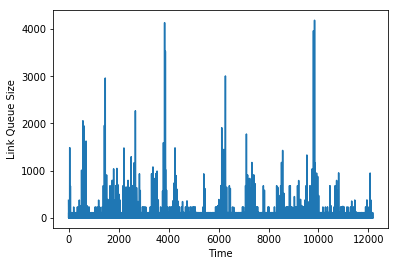

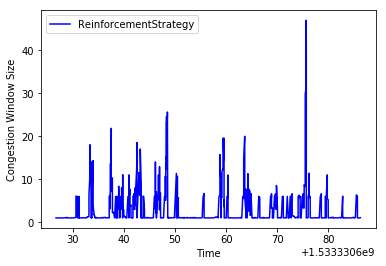

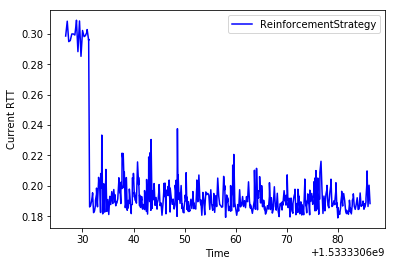

***Episode # 1***
[sender] Connected to receiver: 100.64.0.8:45268

Results for sender 40543, with strategy: ReinforcementStrategy
**Throughput:**                           1152.000000 bytes/s
**Average RTT:**                          198.488469 ms



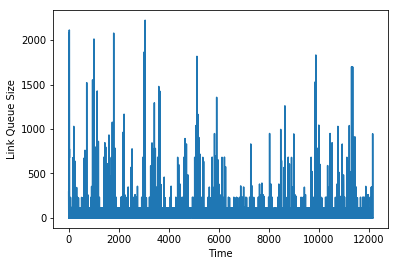

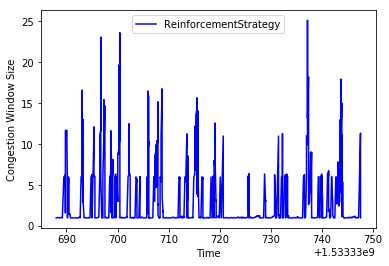

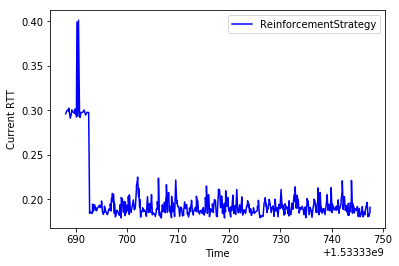

***Episode # 2***
[sender] Connected to receiver: 100.64.0.10:60131

Results for sender 49398, with strategy: ReinforcementStrategy
**Throughput:**                           1369.333333 bytes/s
**Average RTT:**                          198.527765 ms



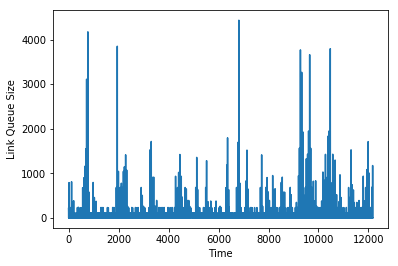

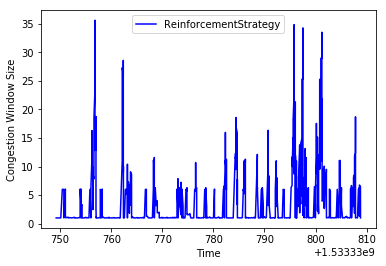

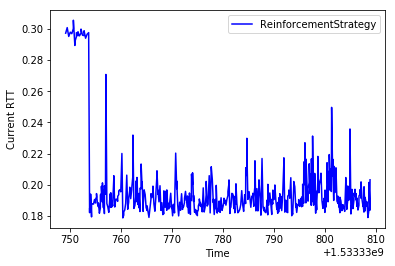

***Episode # 3***
[sender] Connected to receiver: 100.64.0.12:47630

Results for sender 55315, with strategy: ReinforcementStrategy
**Throughput:**                           1386.666667 bytes/s
**Average RTT:**                          198.964567 ms



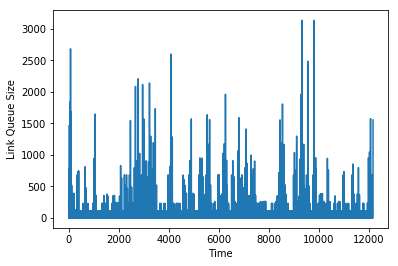

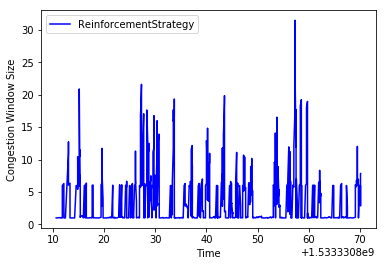

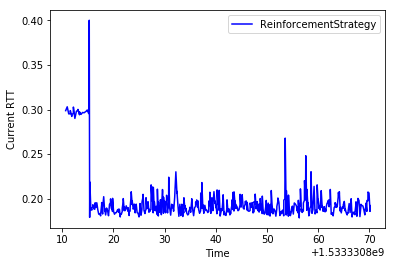

***Episode # 4***
[sender] Connected to receiver: 100.64.0.12:36270

Results for sender 37438, with strategy: ReinforcementStrategy
**Throughput:**                           1606.666667 bytes/s
**Average RTT:**                          203.369627 ms



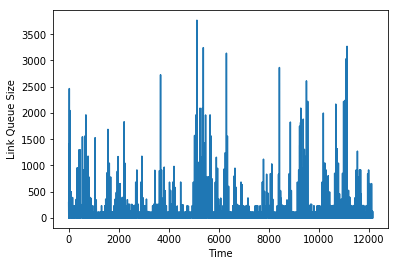

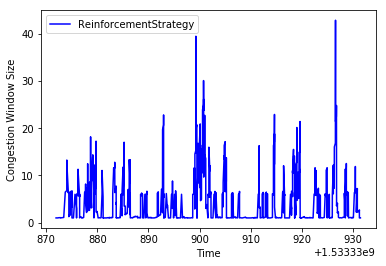

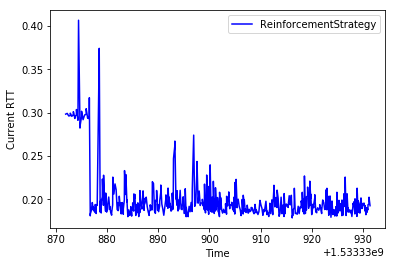

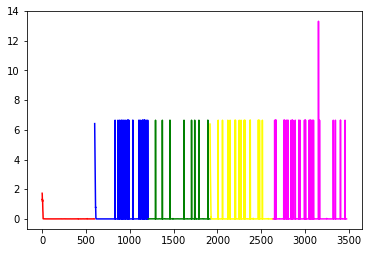

In [6]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}


policy_net = LSTM_DQN(config)
target_net = LSTM_DQN(config)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.RMSprop(policy_net.parameters())
transitions = []
total_losses = []
for i in range(NUM_EPISODES):
    port = get_open_udp_port()
    strategy = ReinforcementStrategy(policy_net, target_net, optimizer, config, i, transitions)
    print("***Episode # %d***" % i)
    run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strategy)])
    total_losses.append(strategy.losses)
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

colors = ["red", "blue", "green", "yellow", "magenta"]
start = 0
for i,loss_array in enumerate(total_losses):
    x = list(range(start, start + len(loss_array)))
    plt.plot(x, loss_array, c=colors[i % 5])
    start += len(loss_array)
    
plt.show()

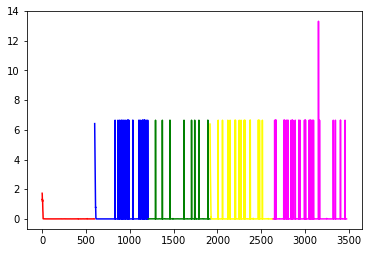

In [7]:
colors = ["red", "blue", "green", "yellow", "magenta"]
start = 0
for i,loss_array in enumerate(total_losses):
    x = list(range(start, start + len(loss_array)))
    plt.plot(x, loss_array, c=colors[i % 5])
    start += len(loss_array)
    
plt.show()